# Deep learning: Convolutional Neural Networks applied on MNIST

6. Deep learning applied on MNIST
7. Summary of the deep learning Neural Network
8. Define functions and train the model
9. Evaluate the model

## 6. Deep learning applied on MNIST

In the first part, we learned how to use a simple ANN to classify MNIST. Now we are going to expand our knowledge using a Deep Neural Network.

Architecture of our network is:

*   (Input) -> \[batch_size, 28, 28, 1]  >> Apply 32 filter of \[5x5]
*   (Convolutional layer 1)  -> \[batch_size, 28, 28, 32]
*   (ReLU 1)  -> \[?, 28, 28, 32]
*   (Max pooling 1) -> \[?, 14, 14, 32]
*   (Convolutional layer 2)  -> \[?, 14, 14, 64]
*   (ReLU 2)  -> \[?, 14, 14, 64]
*   (Max pooling 2)  -> \[?, 7, 7, 64]
*   \[fully connected layer 3] -> \[1x1024]
*   \[ReLU 3]  -> \[1x1024]
*   \[Drop out]  -> \[1x1024]
*   \[fully connected layer 4] -> \[1x10]

The next cells will explore this new architecture.

In [ ]:
import tensorflow as tf

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train, x_test = x_train / 255.0, x_test / 255.0

In [ ]:
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

**Initial parameters**

Create general parameters for the model

In [ ]:
#Dimension for the image shape
width = 28
height = 28
flat = width * height   #Number of pixel in one image
class_output = 10       #Number of labels

**Converting images of the data set to tensor**

The input image is 28 pixels by 28 pixels, 1 channel (grayscale). In this case, the first dimension is the batch number of the image, and can be of any size (so we set it to -1). The second and third dimensions are width and height, and the last one is the image channels.

In [ ]:
x_image_train = tf.reshape(x_train, [-1, 28, 28, 1])
x_image_train = tf.cast(x_image_train, "float32")

x_image_test = tf.reshape(x_test, [-1, 28, 28, 1])
x_image_test = tf.cast(x_image_test, "float32")

train_ds = tf.data.Dataset.from_tensor_slices((x_image_train, y_train)).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_image_test, y_test)).batch(50)

In [ ]:
x_image_train = tf.slice(x_image_train, [0, 0, 0, 0], [10000, 28, 28, 1])
y_train = tf.slice(y_train, [0, 0], [10000, 10])

### Convolutional Layer 1

**Defining kernel weights and bias**

We define a kernel here. The Size of the filter/kernel is 5x5; Input channels is 1 (grayscale); and we need 32 different feature maps (here, 32 feature maps means 32 different filters are applied on each image. So, the output of convolution layer would be 28x28x32). In this step, we create a filter / kernel tensor of shape `[filter_height, filter_width, in_channels, out_channels]`

In [ ]:
W_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev = 0.1, seed = 0))
b_conv1 = tf.Variable(tf.constant(0.1, shape = [32]))

<img src="https://ibm.box.com/shared/static/vn26neef1nnv2oxn5cb3uueowcawhkgb.png" style="width: 800px; height: 400px;" alt="HTML5 Icon" >

To create convolutional layer, we use `tf.nn.conv2d`. It computes a 2-D convolution given 4-D input and filter tensors.

Inputs:

*   tensor of shape \[batch, in_height, in_width, in_channels]. x of shape \[batch_size,28 ,28, 1]

*   a filter / kernel tensor of shape \[filter_height, filter_width, in_channels, out_channels]. W is of size \[5, 5, 1, 32]

*   stride which is  \[1, 1, 1, 1]. The convolutional layer, slides the "kernel window" across the input tensor. As the input tensor has 4 dimensions:  \[batch, height, width, channels], then the convolution operates on a 2D window on the height and width dimensions. **strides** determines how much the window shifts by in each of the dimensions. As the first and last dimensions are related to batch and channels, we set the stride to 1. But for second and third dimension, we could set other values, e.g. \[1, 2, 2, 1]

Process:

*   Change the filter to a 2-D matrix with shape \[5\*5\*1,32]
*   Extracts image patches from the input tensor to form a *virtual* tensor of shape `[batch, 28, 28, 5*5*1]`.
*   For each batch, right-multiplies the filter matrix and the image vector.

Output:

*   A `Tensor` (a 2-D convolution) of size tf.Tensor 'add\_7:0' shape=(?, 28, 28, 32)- Notice: the output of the first convolution layer is 32 \[28x28] images. Here 32 is considered as volume/depth of the output image.

In [ ]:
def convolve1(x):
  return tf.nn.conv2d(x, W_conv1, strides = [1, 1, 1, 1], padding = "SAME") + b_conv1

<img src="https://ibm.box.com/shared/static/iizf4ui4b2hh9wn86pplqxu27ykpqci9.png" style="width: 800px; height: 400px;" alt="HTML5 Icon" >

**Apply the ReLU activation function**

In this step, we just go through all outputs convolution layer, convolve1, and wherever a negative number occurs, we swap it out for a 0. It is called ReLU activation Function.
Let f(x) is a ReLU activation function:

$f(x) = max(0, X)$

In [ ]:
def act_function_relu(x):
  return tf.nn.relu(convolve1(x))

**Aplly the max pooling**

max pooling is a form of non-linear down-sampling. It partitions the input image into a set of rectangles and, then find the maximum value for that region.

Lets use `tf.nn.max_pool` function to perform max pooling. Kernel size: 2x2 (if the window is a 2x2 matrix, it would result in one output pixel)\ Strides: dictates the sliding behaviour of the kernel. In this case it will move 2 pixels everytime, thus not overlapping. The input is a matrix of size 28x28x32, and the output would be a matrix of size 14x14x32.

<img src="https://ibm.box.com/shared/static/kmaja90mn3aud9mro9cn8pbbg1h5pejy.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 

In [ ]:
def conv1(x):
  return tf.nn.max_pool(act_function_relu(x), ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")

### Convolutional Layer 2

**Weights and Biases of Kernels**

We apply the convolution again in this layer. Lets look at the second layer kernel:

* Filter/kernel: 5x5 (25 pixels)
* Input channels: 32 (from the 1st Conv layer, we had 32 feature maps)
* 64 output feature maps


Notice: here, the input image is [14x14x32], the filter is [5x5x32], we use 64 filters of size [5x5x32], and the output of the convolutional layer would be 64 convolved image, [14x14x64].

Notice: the convolution result of applying a filter of size [5x5x32] on image of size [14x14x32] is an image of size [14x14x1], that is, the convolution is functioning on volume.

In [ ]:
W_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev = 0.1, seed = 0))
b_conv2 = tf.Variable(tf.constant(0.1, shape = [64]))

Convolve image weight tensor and add biases

In [ ]:
def convolve2(x):
  return tf.nn.conv2d(conv1(x), W_conv2, strides = [1, 1, 1, 1], padding = "SAME") + b_conv2

applt the ReLU activation function

In [ ]:
def act_function_relu2(x):
  return (tf.nn.relu(convolve2(x)))

Apply the max pooling

In [ ]:
def conv2(x):
  return tf.nn.max_pool(act_function_relu2(x), ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = "SAME")

The output of the second layer it is a 64 matrix of [7x7]

### Full connected layer

You need a fully connected layer to use the Softmax and create the probabilities in the end. Fully connected layers take the high-level filtered images from previous layer, that is all 64 matrices, and convert them to a flat array.

So, each matrix [7x7] will be converted to a matrix of [49x1], and then all of the 64 matrix will be connected, which make an array of size [3136x1]. We will connect it into another layer of size [1024x1]. So, the weight between these 2 layers will be [3136x1024]

<img src="https://ibm.box.com/shared/static/pr9mnirmlrzm2bitf1d4jj389hyvv7ey.png" alt="HTML5 Icon" style="width: 800px; height: 400px;"> 

**Flattering Second layer**


In [ ]:
def layer2_matrix(x):
  return tf.reshape(conv2(x), [-1, 7 * 7 * 64])

**Weigths and Biases between lñayer 2 and 3**

Composition of the feature map from the last layer (7x7) multiplied by the number of feature maps (64); 1027 outputs to Softmax layer

In [ ]:
w_fc1 = tf.Variable(tf.random.truncated_normal([7 * 7 * 64, 1024], stddev = 0.1, seed = 2))
b_fc1 = tf.Variable(tf.constant(0.1, shape = [1024]))

**Matrix multipplication (applying weightd and biases)**


In [ ]:
def fc1(x):
  return tf.matmul(layer2_matrix(x), w_fc1) + b_fc1

**Apply the ReLU activation function**


In [ ]:
def act_function_relu3(x):
  return tf.nn.relu(fc1(x))

### Dropout Layer

This is an optional phase for reducing overfitting

It is a phase where the network "forget" some features. At each training step in a mini-batch, some units get switched off randomly so that it will not interact with the network. That is, it weights cannot be updated, nor affect the learning of the other network nodes. This can be very useful for very large neural networks to prevent overfitting.

In [ ]:
keep_prob = 0.5

def layer_drop(x):
  return tf.nn.dropout(act_function_relu3(x), keep_prob)

**Readout Layer (Softmaw Layer)**

Type: Softmax, fully connected layer

**Weight and biases**

In last layer, CNN takes the high-level filtered images and translate them into votes using softmax. Input channels: 1024 (neurons from the 3rd Layer); 10 output features

In [ ]:
w_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev = 0.1, seed = 2))
b_fc2 = tf.Variable(tf.constant(0.1, shape = [10]))

**Matrix multipplication (applying weightd and biases)**


In [ ]:
def fc2(x):
  return tf.matmul(layer_drop(x), w_fc2) + b_fc2

**Apply the softmax activation function**

In [ ]:
def y_softmax(x):
  return tf.nn.softmax(fc2(x))

## 7. Summary of the Deep Convolutional Neural Network

* Input - MNIST dataset
* Convolutional and Max-pooling
* Convolutional and Max-pooling
* Fully Connected layer
* Processing - Dropout
* Readout layer - Fully connected
* Outputs - Classified digits

## 8. Define functions and train the model

**Define the loss function**

We need to compare our output, layer4 tensor, with ground truth for all mini_batch. we can use cross entropy `b` to see how bad our CNN is working - to measure the error at a softmax layer.

The following code shows an toy sample of cross-entropy for a mini-batch of size 2 which its items have been classified. You can run it (first change the cell type to code in the toolbar) to see how cross entropy changes.

In [ ]:
import numpy as np
 
layer4_test = [[0.9, 0.1, 0.1], [0.9, 0.1, 0.1]]
y_test = [[1, 0, 0], [1, 0, 0]]

np.mean(-np.sum(y_test * np.log(layer4_test), 1))

0.10536051565782628

reduce_sum computes the sum of elements of y * tf.log(layer4) across second dimension of the tensor, and reduce_mean computes the mean of all elements in the tensor.

$CrossEntropy = \sum y_{label} \cdot log(y_{prediction})$

In [ ]:
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

**Defining the optimizer**

It is obvious that we want minimize the error of our network which is calculated by cross_entropy metric. To solve the problem, we have to compute gradients for the loss (which is minimizing the cross-entropy) and apply gradients to variables. It will be done by an optimizer: **GradientDescent** or **Adagrad.**

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)

Following the convention of our first example, we will use **GradientTape** to define a model.

In [ ]:
variables = [W_conv1, b_conv1, W_conv2, b_conv2, 
             w_fc1, b_fc1, w_fc2, b_fc2, ]

def train_step(x, y):
  with tf.GradientTape() as tape:
    current_loss = cross_entropy(y, y_softmax(x))
    grads = tape.gradient(current_loss, variables)
    optimizer.apply_gradients(zip(grads, variables))
    return current_loss.numpy()

**Define prediction**

In [ ]:
correct_prediction = tf.equal(tf.argmax(y_softmax(x_image_train), axis=1), tf.argmax(y_train, axis=1))

**Define accuracy**



In [ ]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float32'))

**Run session and train**


In [ ]:
loss_values=[]
accuracies = []
epochs = 1

for epoch in range(epochs):
    batch = 0
    # each batch has 50 examples
    for x_train_batch, y_train_batch in train_ds:
        batch += 1
        current_loss = train_step(x_train_batch, y_train_batch)

        if batch % 50 == 0: #reporting intermittent batch statistics
            correct_prediction = tf.equal(tf.argmax(y_softmax(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
            #  accuracy
            accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
            print("epoch ", str(epoch), "batch", str(batch), "loss:", str(current_loss),
                     "accuracy", str(accuracy)) 
            
    current_loss = cross_entropy( y_train, y_softmax( x_image_train )).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(y_softmax(x_image_train), axis=1),
                                  tf.argmax(y_train, axis=1))
    #  accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print("end of epoch ", str(epoch), "loss", str(current_loss), "accuracy", str(accuracy) ) 

epoch  0 batch 50 loss: 141.75606 accuracy 0.32
epoch  0 batch 100 loss: 59.031296 accuracy 0.72
epoch  0 batch 150 loss: 35.671795 accuracy 0.74
epoch  0 batch 200 loss: 35.593155 accuracy 0.82
epoch  0 batch 250 loss: 44.849487 accuracy 0.78
epoch  0 batch 300 loss: 28.509315 accuracy 0.82
epoch  0 batch 350 loss: 31.482727 accuracy 0.84
epoch  0 batch 400 loss: 12.52626 accuracy 0.9
epoch  0 batch 450 loss: 19.943563 accuracy 0.84
epoch  0 batch 500 loss: 11.631872 accuracy 0.92
epoch  0 batch 550 loss: 10.699755 accuracy 0.9
epoch  0 batch 600 loss: 26.553905 accuracy 0.82
epoch  0 batch 650 loss: 20.633434 accuracy 0.76
epoch  0 batch 700 loss: 2.7538722 accuracy 0.94
epoch  0 batch 750 loss: 23.169407 accuracy 0.86
epoch  0 batch 800 loss: 13.845081 accuracy 0.92
epoch  0 batch 850 loss: 20.085352 accuracy 0.9
epoch  0 batch 900 loss: 13.578524 accuracy 0.92
epoch  0 batch 950 loss: 12.643195 accuracy 0.92
epoch  0 batch 1000 loss: 17.674732 accuracy 0.94
epoch  0 batch 1050 loss

NameError: ignored

**Evualuate the model**



In [ ]:
batch = 0
acccuracies=[]
# evaluate accuracy by batch and average...reporting every 100th batch
for x_train_batch, y_train_batch in train_ds:
        batch += 1
        correct_prediction = tf.equal(tf.argmax(y_softmax(x_train_batch), axis=1),
                                  tf.argmax(y_train_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        accuracies.append(accuracy)
        if batch % 100 == 0:
            print("batch", str(batch), "accuracy", str(accuracy)) 

print("accuracy of entire set", str(np.mean(accuracies))) 

batch 100 accuracy 0.96
batch 200 accuracy 1.0
batch 300 accuracy 0.94
batch 400 accuracy 0.98
batch 500 accuracy 0.9
batch 600 accuracy 0.96
batch 700 accuracy 0.96
batch 800 accuracy 0.9
batch 900 accuracy 0.92
batch 1000 accuracy 0.9
batch 1100 accuracy 0.96
batch 1200 accuracy 0.98
accuracy of entire set 0.9401684


**Visualization**

do you want to look all the filters?

In [ ]:
kernels = tf.reshape(tf.transpose(W_conv1, perm=[2, 3, 0,1]),[32, -1])

In [ ]:
!wget --output-document utils1.py https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py


--2022-04-17 06:01:46--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DL0120EN-SkillsNetwork/labs/Week2/data/utils.py
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5097 (5.0K) [text/x-python]
Saving to: ‘utils1.py’

utils1.py           100%[===================>]   4.98K  --.-KB/s    in 0s      

2022-04-17 06:01:46 (489 MB/s) - ‘utils1.py’ saved [5097/5097]



In [ ]:
import utils1
import imp
imp.reload(utils1)
from utils1 import tile_raster_images
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

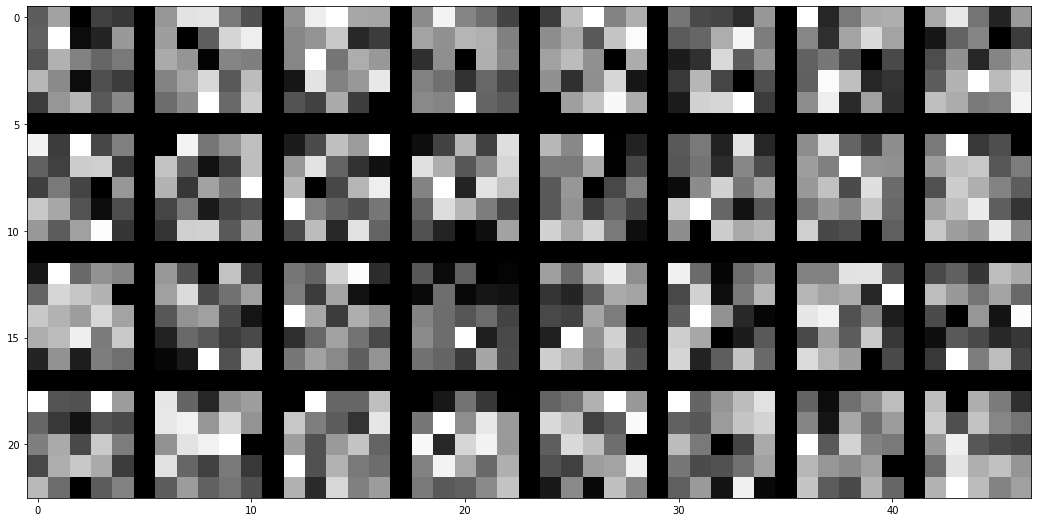

In [ ]:
image = Image.fromarray(tile_raster_images(kernels.numpy(), img_shape=(5, 5) ,tile_shape=(4, 8), tile_spacing=(1, 1)))
### Plot image
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')  

Do you want to see the output of an image passing through first convolution layer?

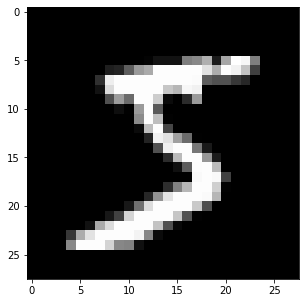

In [ ]:
plt.rcParams['figure.figsize'] = (5.0, 5.0)
sampleimage = [x_image_train[0]]
plt.imshow(np.reshape(sampleimage,[28,28]), cmap="gray")